# 세계 대기질 관측 데이터을 활용한 분석

**대기질(AQI)과 가장 연관성이 높은 오염 물질을 식별**하고,  
**출,퇴근 시간대 및 국가별 PM2.5패턴 분석**


## <p style="text-align: right;"> 이진수
###### <p style="text-align: right;"> 기간 2025-12-17 ~ 2025-12-20 

## 1. 프로젝트 개요 및 분석내용
### 프로젝트 개요

### 분석 내용
- AQI와 가장 높은 상관을 보이는 오염 물질은 무엇인가?  
- 출·퇴근 시간대의 PM2.5 농도는 다른 시간대와 차이가 있는가?  
- 국가별 평균 PM2.5는 어떻게 다른가?  

## 2. 환경 설정 및 분석 준비

In [43]:
# 프로젝트 루트 경로 유지
from pathlib import Path

BASE_DIR = Path.cwd()
if BASE_DIR.name == "notebooks":
    BASE_DIR = BASE_DIR.parent

In [44]:
# 라이브러리
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sqlite3

In [45]:
# 한글 폰트 설정
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

## 3. 데이터 구조 및 품질 확인

In [46]:
df = pd.read_csv(BASE_DIR/"data"/"globalAirQuality.csv")

In [47]:
df

,timestamp,country,city,latitude,longitude,pm25,pm10,no2,so2,o3,co,aqi,temperature,humidity,wind_speed
0,2025-11-04 18:25:17.554219,US,New York,40.713,-74.006,50.295,108.938,27.998,6.539,52.568,1.096,108,18.504,70.168,3.725
1,2025-11-04 19:25:17.554219,US,New York,40.713,-74.006,32.083,63.043,36.120,4.021,43.536,1.075,90,5.838,80.088,8.969
2,2025-11-04 20:25:17.554219,US,New York,40.713,-74.006,42.250,82.553,26.935,9.538,23.320,0.977,84,31.833,62.783,9.650
3,2025-11-04 21:25:17.554219,US,New York,40.713,-74.006,30.403,79.951,63.536,7.609,31.369,0.230,158,23.140,89.153,8.956
4,2025-11-04 22:25:17.554219,US,New York,40.713,-74.006,21.083,66.423,38.997,6.919,45.615,1.085,97,13.632,76.499,4.017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,2025-11-19 13:25:17.554219,CH,Zurich,47.377,8.542,27.899,74.179,41.474,6.677,50.869,1.028,103,7.079,52.443,7.452
17996,2025-11-19 14:25:17.554219,CH,Zurich,47.377,8.542,2.950,47.988,42.235,2.821,35.551,0.644,105,28.734,85.678,4.496
17997,2025-11-19 15:25:17.554219,CH,Zurich,47.377,8.542,61.347,72.908,46.976,5.763,66.492,0.947,122,21.951,72.311,9.660
17998,2025-11-19 16:25:17.554219,CH,Zurich,47.377,8.542,40.722,95.152,32.957,5.524,53.193,0.868,95,24.042,31.880,2.642


In [48]:
# SQL
conn = sqlite3.connect(BASE_DIR / "db" / "air_quality.db")

In [49]:
pd.read_sql("PRAGMA table_info(air_quality)", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,timestamp,TEXT,0,None,0
1,1,country,TEXT,0,None,0
2,2,city,TEXT,0,None,0
3,3,latitude,REAL,0,None,0
4,4,longitude,REAL,0,None,0
5,5,pm25,REAL,0,None,0
6,6,pm10,REAL,0,None,0
7,7,no2,REAL,0,None,0
8,8,so2,REAL,0,None,0
9,9,o3,REAL,0,None,0


In [50]:
pd.read_sql("SELECT COUNT(*) FROM air_quality", conn)

,COUNT(*)
0,18000


In [51]:
# 결측치 확인
pd.read_sql("""SELECT 
            SUM(CASE WHEN pm25 IS NULL THEN 1 ELSE 0 END) as pm25,
            SUM(CASE WHEN pm10 IS NULL THEN 1 ELSE 0 END) as pm10,
            SUM(CASE WHEN no2 IS NULL THEN 1 ELSE 0 END) as no2,
            SUM(CASE WHEN so2 IS NULL THEN 1 ELSE 0 END) as so2,
            SUM(CASE WHEN o3 IS NULL THEN 1 ELSE 0 END) as o3,
            SUM(CASE WHEN co IS NULL THEN 1 ELSE 0 END) as co,
            SUM(CASE WHEN aqi IS NULL THEN 1 ELSE 0 END) as aqi
            FROM air_quality""",conn)

,pm25,pm10,no2,so2,o3,co,aqi
0,0,0,0,0,0,0,0


In [52]:
# PM2.5(미세먼지) 이상치 확인
pd.read_sql("SELECT COUNT(*) as pm25 FROM air_quality WHERE pm25 < 0",conn)

,pm25
0,0


In [53]:
# 데이터 수집 기간 확인
pd.read_sql("SELECT MIN(timestamp) as min, MAX(timestamp) as max FROM air_quality;", conn)


,min,max
0,2025-11-04 18:25:17.554219,2025-11-19 17:25:17.554219


### 데이터 확인 결과  

- 전체 데이터는 총**18,000건**으로 구성
- 대기 오염물질 결측치 없음.
- PM2.5(미세먼지)에 이상치 없음
- 데이터 수집 기간은 2025년 11월4일 18시 ~ 2025년 11월 19일 17시

## 4. 데이터 전처리

### 4-1 시간 전처리

시간대별 분석을 하기 위해서 timestamp 칼럼을 datetime 형식으로 변환하고,  
날짜를 제외하고 시간(hour) 데이터만 추출

In [54]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [55]:
df['hour'] = df['timestamp'].dt.hour

In [56]:
df['hour']

0        18
1        19
2        20
3        21
4        22
         ..
17995    13
17996    14
17997    15
17998    16
17999    17
Name: hour, Length: 18000, dtype: int32

### 4-2 국가명 전처리
국가 이름이 코드 형태라 분석 결과을 볼 때 불편할 것 같아서  
국가 코드를 한글 국가명으로 매핑

In [57]:
# 국가명 확인
df[['country']].drop_duplicates().head()

,country
0,US
720,GB
1080,FR
1440,DE
1800,ES


In [58]:
map_df = pd.read_csv(BASE_DIR / "data" / "kor_mapping.csv", encoding="cp949")

In [59]:
map_df.columns

Index(['country_code_2', 'country_code_3', 'country_num', 'continent_name',
       'continent_kor_name', 'continent_mofa_name', 'eng', 'kor'],
      dtype='object')

#### 4-2-1 국가명 표준화

원본 데이터의 국가명은 공식 명칭으로 제공되어 있으며,  
분석 결과의 가독성을 위해 "**미합중국**"을 "**미국**"으로 표준화

In [60]:
map_df['kor'].unique()

array(['가나', '가봉', '가이아나', '감비아', '건지', '과들루프', '과테말라', '괌', '교황청',
       '그레나다', '그리스', '그린란드', '기니', '기니비사우', '나미비아', '나우루', '나이지리아',
       '남수단', '남아프리카공화국', '네덜란드', '네덜란드령 안틸레스', '네팔연방', '노르웨이', '노퍽섬',
       '뉴 칼레도니아', '뉴질랜드', '니우에', '니제르', '니카라과', '대만', '대한민국', '덴마크',
       '도미니카공화국', '도미니카연방', '독일', '동티모르', '라오스', '라이베리아', '라트비아', '러시아',
       '레바논', '레소토', '레위니옹', '루마니아', '룩셈부르크', '르완다', '리비아', '리투아니아',
       '리히텐슈타인', '마다가스카르', '마르티니크', '마셜제도', '마요트', '마이크로네시아연방', '마카오',
       '말라위', '말레이시아', '말리', '맨 섬', '멕시코', '모나코', '모로코', '모리셔스', '모리타니아',
       '모잠비크', '몬테네그로', '몬트세랫', '몰도바', '몰디브', '몰타', '몽골', '미국령 군소 제도',
       '미국령 버진아일랜드', '미얀마', '미합중국', '바누아투', '바레인', '바베이도스', '바하마',
       '방글라데시', '버뮤다', '베냉', '베네수엘라볼리바르', '베트남', '벨기에', '벨라루스', '벨리즈',
       '보네르섬', '보스니아헤르체고비나', '보츠와나', '볼리비아', '부룬디', '부르키나파소', '부탄',
       '북마리아나 군도', '북마케도니아', '불가리아', '브라질', '브루나이', '사모아', '사우디아라비아',
       '사이프러스', '사하라 아랍민주공화국(서부사하라)', '산마리노', '상투메프린시페', '생바르텔레미',
       '생피에르·미클롱', '세네

In [76]:
map_df["kor"] = map_df["kor"].replace({"미합중국":"미국"})

#### 4-2-2 국가 코드 문자열 정규화

조인 과정에서 발생할 수 있는 불일치를 방지하기 위해  
문자열 정규화(공백 제거 및 대·소문자 통일)

In [77]:
#국가 코드 문자열 정규화
df["country"] = df["country"].astype(str).str.strip().str.upper()
map_df["country_code_2"] = map_df["country_code_2"].astype(str).str.strip().str.upper()

In [63]:
#국가명 매핑
df = df.merge(
    map_df[["country_code_2", "kor"]].rename(columns={"country_code_2": "country", "kor": "country_kor"}),
    on="country",
    how="left"
)

In [64]:
#매핑 확인
unmapped = df.loc[df["country_kor"].isna(), "country"].unique()
unmapped[:20], len(unmapped)

(array([], dtype=object), 0)

In [65]:
df[['country','country_kor']].drop_duplicates()

,country,country_kor
0,US,미국
720,GB,영국
1080,FR,프랑스
1440,DE,독일
1800,ES,스페인
2160,IT,이탈리아
2520,CA,캐나다
2880,MX,멕시코
3240,BR,브라질
3600,AR,아르헨티나


## 5. 데이터 분석

### 5-1 대기질과 오염물질 상관 관계

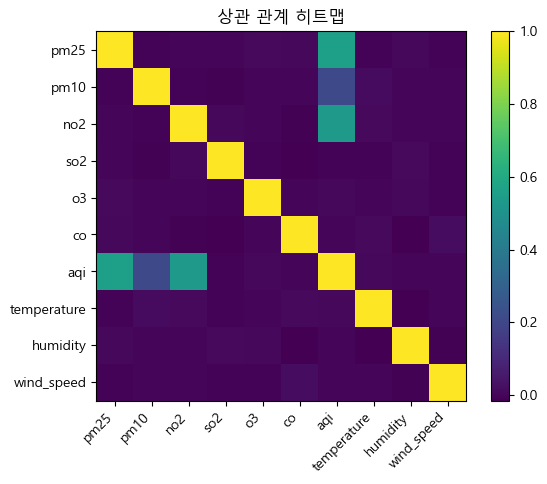

In [66]:
corr = df[['pm25','pm10','no2','so2','o3','co','aqi','temperature','humidity','wind_speed']].corr()

plt.imshow(corr, interpolation = "nearest")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("상관 관계 히트맵")
plt.show()

In [67]:
corr_aqi = df[['aqi','pm25','pm10','no2']].corr()['aqi'].sort_values(ascending=False)
corr_aqi

aqi     1.000000
pm25    0.556094
no2     0.531731
pm10    0.207499
Name: aqi, dtype: float64

- Aqi(대기질)과 강한 상관관계를 보이는 물질은 PM2.5(초미세먼지), NO2(질소이산화물)이고    
약한 상관 관계를 보이는 물질은 PM10(미세먼지)이다.

### 5-2 출·퇴근시간 PM2.5 분석

일반적인 통근 시간대를 고려해서 출퇴근 시간대 정의  
출근 시간대 : 07-09시  
퇴근 시간대 : 18-20시

In [68]:
# 시간대별 PM2.5
hour_pm25 = df.groupby('hour')['pm25'].mean()

In [69]:
hour_pm25

hour
0     40.423276
1     40.415724
2     40.385668
3     40.914781
4     40.427199
5     40.877992
6     39.623785
7     40.869288
8     40.051621
9     40.245088
10    39.447483
11    40.253725
12    40.801637
13    40.092973
14    41.061679
15    39.622416
16    40.798513
17    40.203960
18    40.406955
19    41.459813
20    39.131392
21    40.316805
22    40.363275
23    40.664104
Name: pm25, dtype: float64

In [70]:
# PM2.5 중앙값
pm25_median = df['pm25'].median()
pm25_median

40.2865

In [71]:
# 출·퇴근 시간 구분
def time_group(hour):
    if 7 <= hour <= 9:
        return '출근'
    elif 18 <= hour <= 20:
        return '퇴근'
    else:
        return '기타'

df['time_group'] = df['hour'].apply(time_group)

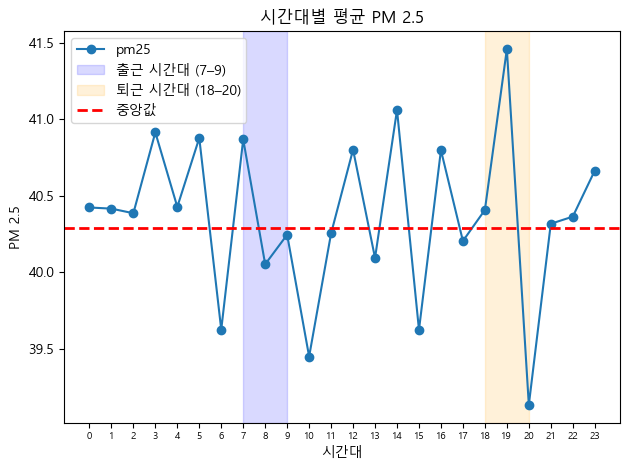

In [73]:
# 시간대별 평균 PM2.5 그래프
hour_pm25.plot(marker='o')

#출,퇴근 시간 표시
plt.axvspan(7, 9, color='blue', alpha=0.15, label='출근 시간대 (7–9)')
plt.axvspan(18, 20, color='orange', alpha=0.15, label='퇴근 시간대 (18–20)')

#중앙값
plt.axhline(
    y=pm25_median,
    color='red',
    linestyle='--',
    linewidth=2,
    label='중앙값')

plt.title("시간대별 평균 PM 2.5")
plt.xticks(range(24),fontsize = 7)
plt.xlabel("시간대")
plt.ylabel("PM 2.5")
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
df.groupby('time_group')[['pm25']].mean()

,pm25
time_group,
기타,40.371944
출근,40.388666
퇴근,40.332720


출·퇴근 시간대에서 PM2.5가 다소 높은 구간이 관찰되었으나,  
그 외 다른 시간대와 비교했을 때 예상보다 차이가 나지 않은 결과가 나타났다.

이는 PM2.5가 교통외에 다른 다양한 배출원이나 기상의 영향을 받기 때문이라 생각한다.

### 5-3 국가별 평균 PM2.5 분석

국제기구 보고서 기준으로  
PM2.5가 상대적으로 농도가 높은 지역은 주로 남아시아와 중앙아시아, 아프리카지역  
농도가 낮은 지역은 오세아니아와 북유럽 일부 국가으로 분류된다.

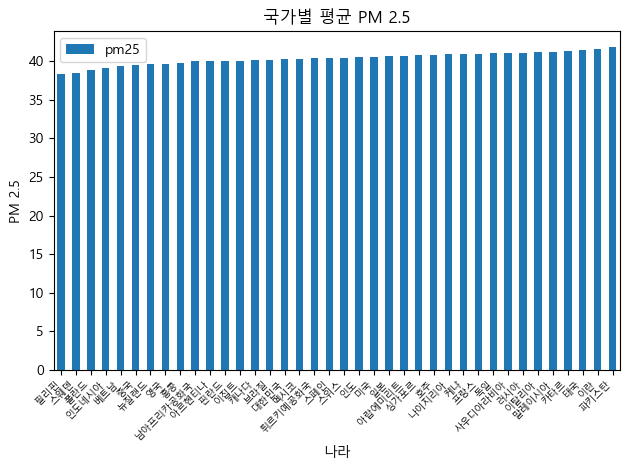

In [74]:
avg_pm25 = df.groupby('country_kor')['pm25'].mean().sort_values()
avg_pm25.plot(kind="bar")

plt.title("국가별 평균 PM 2.5")
plt.xticks(fontsize = 7,rotation = 45,ha='right')
plt.xlabel("나라")
plt.ylabel("PM 2.5")
plt.legend()
plt.tight_layout()
plt.show()

농도가 높은 지역(TOP 6): 파키스탄, 이란, 태국, 카타르, 말레이시아, 이탈리아  
농도가 낮은 지역(TOP 6): 필리핀, 스웨덴, 폴란드, 인도네시아, 베트남, 중국

분석 기간이 제한적이기 때문에 기존에 알려진 것과 예상과 다른 결과가 나타났다.

## 6. 결론 및 한계

### 결론
- AQI에 PM2.5가 가장 높은 상관관계를 보였다.

- 출·퇴근 시간대가 다른시간대보다 교통량이 더 많기에 평균 PM2.5 높을 것이라 예상했지만  
차이를 별로 보이지 않았다.

- 국가별 평균 2.5는 분석 기간이 제한적이라서 기존에 알려진 내용과는 다른 국가들이 나온 것 같다.

### 한계
- 기간이 제한적이라서 절대적인 결과 값이 아닌 상대적인 경향으로 해석해야할 것 같다.